In [ ]:
! pip install mxnet-cu92
! pip install d2l

In [39]:
!pip install matplotlib==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 7.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.8.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.7.3 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.


In [4]:
!pip install d2l==1.0.0-alpha1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.0 MB/s 
  Attempting uninstall: d2l
    Found existing installation: d2l 0.17.5
    Uninstalling d2l-0.17.5:
      Successfully uninstalled d2l-0.17.5



# 3.2 Object-oriented design for implementation
Definig classes for theses objects and their interactions. This ojbect-oreinted design for implementation will greatly streamline the presentation and you migth even want to use it in your projects



We want to have 3 classes: (i) Module contains model, losses ,and optimization methods; (ii) DataModule provides data loaders for trainig and validation;(iii) both classes are cobined using the trained classs, wich allow us to train models on a variatyof hardware platforms. 

### Import Libraries

In [5]:
import time 
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Utilities
The class difinitions tend to be fairly long blocks codes, and the notebook readbability demands short code fragments interspersed with explanatiosn, a requitement incompatible with the style of programming common for python. \\

The first utility functions allows us to register functions as method in a classs after the class has been created. in fact, we can do so even after we've created isntance of the class 

In [6]:
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class, obj.__name__,obj)
  return wrapper 

quick example. WE pan to implement a class A with method do. Instead of having code for both A and do in the same code blocj, we can first declare class A and create instance a


In [29]:
class A:
  def _int_(self):
    self.b=1
a=A()

Next we define the method `do` as we normally would, but not in class `A`'s scope. Instead, we decorate this method by `add_to_class` with class `A` as its argument. In doing so, the method is able to access the member variables of `A` as we would expect if it had been defined as part of `A`'s definition. Let's see what happens when we invoke it for the instance `a`.

In [30]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

The second is a utility class that savea all arguments in a class's ´_int_´ method as class attributes. This allow us to extend cosntructor call signatures implicity without additional code.


In [32]:
class HyperParameters:
  def save_hyperparameters(self, ignore=[]):
    raise NotImplemented

In [33]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


The last utility allos us to plot experiment progress interactiveñy while it is going on

In [37]:
class ProgressBoard(d2l.HyperParameters):  ##save
    """Plot data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

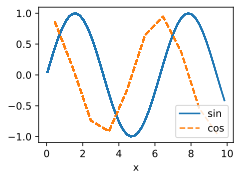

In [40]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

## Model 
The module class is the base class of all modl we will implement. At a minimun we need to define three methods. The ´_int_´ method stores the learneable parameters, the  ´training_step´ method accpets a data batch to return the loss value, the parameters. Optinionally we can define ´validation´ to report the evaluation measures. Sometimes we put the code to compute the output into seprate forward method to majeit more reusable

In [42]:
class Module(nn.Module, d2l.HyperParameters):  ##save
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

## Data 
The DataModule class is the base class for data. Quite frequently the _init_ method is used to prepare the data. This includes downloading and preprocessing if needed. The train_dataloader returns the data loader for the training dataset. A data loader is a (Python) generator that yields a data batch each time it is used. This batch is then fed into the training_step method of Module to compute the loss. There is an optional val_dataloader to return the validation dataset loader. It behaves in the same manner, except that it yields data batches for the validation_step method in Module.

In [43]:
class DataModule(d2l.HyperParameters):  ##save
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

## Training 
The Trainer class trains the learnable parameters in the Module class with data specified in DataModule. The key method is fit, which accepts two arguments: model, an instance of Module, and data, an instance of DataModule. It then iterates over the entire dataset max_epochs times to train the model. As before, we will defer the implementation of this function to later chapters.

In [46]:
class Trainer(d2l.HyperParameters):  ##save
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError